Selected file: C:/Users/82104/Desktop/preprocess/Test_Images/ad802f72d756badb070bb35fabb0631e.jpg
ad802f72d756badb070bb35fabb0631e
mkdir
mkdir
(846, 564, 3)
load image
846 564


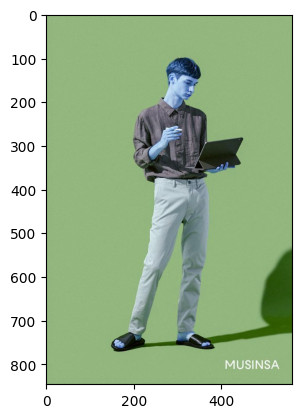

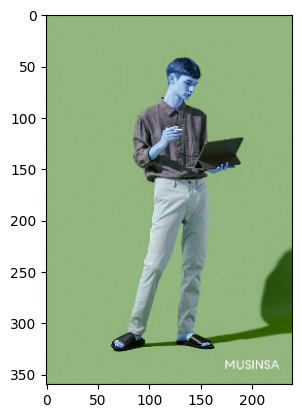

person
사물이 이미지 중심으로 부터 벗어나 있음


In [2]:
import glob
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from tkinter import Tk
from tkinter.filedialog import askopenfilename

# 이미지 파일경로 불러오기
# Tkinter 창 초기화
root = Tk()
root.withdraw()

# 파일 선택 창 열기
img_path = askopenfilename(initialdir='./',)

# 선택한 파일 경로 출력
print("Selected file:", img_path)

img_name = (img_path.split('/')[-1]).split('.')[0]

print(img_name)

crs_list = {}

# prepocessing한 결과물을 저장할 디렉토리 목록 [['./상위], [/하위], [/하위하위]...])
dir_list = [['./Preprocessed','./Original','./Result'],['/Resized', '/CropResized']]

result_size = (240,360)
def mkdir_(path='/new'):
    import os
    # 디렉토리가 이미 존재하는지 확인
    if not os.path.exists(path):
    # 디렉토리 생성
        os.mkdir(path)
        print('mkdir')

    # else:
        # print('exist dir')

def dirPaths(dir_list):
    dir_paths = []
    dir_path = str()
    x = 0
    for idx in range(len(dir_list)):
        if idx == 0:
            for a in dir_list[idx]:
                dir_path = a
                dir_paths.append(dir_path)
                dir_paths_1 = dir_paths.copy()

        else:        
            for b in dir_paths_1:
                for a in dir_list[idx]:
                    if 'Preprocessed' in (b.split('/')):
                        if len(b.split('/')) == idx +1:
                            dir_path = b + a

                            dir_paths.append(dir_path)

            dir_paths_1 = dir_paths.copy()

    return dir_paths    

dir_paths = dirPaths(dir_list)
for path in dir_paths:
        mkdir_(path)

try:
    src = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    print(src.shape)
    print('load image')
except FileNotFoundError:
    print('load failed')
    sys.exit()

if src is None:
    print(f"이미지를 읽을 수 없습니다: {img_path}")
    sys.exit()

else:
    if src.shape[-1] == 4:
        print('BGR조정됨')
        src = cv2.cvtColor(src, cv2.COLOR_BGRA2BGR)
    cv2.imwrite(f'./Original/{img_name}_original.png', src)
    y,x = src.shape[:2]
    # 이미지 사이즈 조정
    image = cv2.resize(src, (int(x), int(y)))
    src_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(src_hsv)
    v_norm = cv2.normalize(v, None, 0,255, cv2.NORM_MINMAX)  
    dst1 = cv2.merge((h,s,v_norm))
    dst_norm = cv2.cvtColor(dst1, cv2.COLOR_HSV2BGR)
    resized = cv2.resize(dst_norm, (result_size[0],result_size[1]))
    img = dst_norm
    if img is None:
        print('image read failed')
        sys.exit()

    ## model import
    model = './yolo_v3/yolov3.weights'
    config = './yolo_v3/yolov3.cfg.txt'

    net = cv2.dnn.readNet(model, config)

    if net.empty():
        print('model load failed')
        sys.exit()

    ## class names
    classNames = []

    with open('./yolo_v3/coco.names.txt', 'rt') as f:
        classNames = f.read().rstrip('\n').split('\n')

    layer_names = net.getLayerNames()
    output_layers = [layer_names[i-1] for i in net.getUnconnectedOutLayers()]
    # print(output_layers)

    # display(classNames)

    blob = cv2.dnn.blobFromImage(img, 1/255., (320,320), swapRB = True)
    net.setInput(blob)
    output = net.forward(output_layers)

    # print(output[0].shape)

    colors = np.random.uniform(0, 255, size = (80, 3))

    ih, iw = img.shape[:2]
    eh = int(ih*0.03)
    ew = int(iw*0.03)

    print(ih,iw)
    class_ids = []
    confidences = []
    boxes = []

    # print(output, len(output))
    for out in output[:5]:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.7:
                cx = int(detection[0]*iw)
                cy = int(detection[1]*ih)
                bw = int(detection[2]*iw)+(2*ew)
                bh = int(detection[3]*ih)+(2*eh)
                sx = int(cx-bw/2)
                sy = int(cy-bh/2)
                if sx < 0:
                    sx = 0
                if sy < 0:
                    sy = 0
                if bh>bw:
                    bw = (bh/6)*4
                    bw = int(bw)
                if bh<bw:
                    bh = (bw/4)*6
                    bh = int(bh)

                boxes.append([sx,sy,bw,bh])
                confidences.append(confidence)
                class_ids.append(int(class_id))

    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.8, 0.6)

    s_cnt = 0
    for i in indices:
        if i:
            if classNames[class_ids[i]]=='person':
                print(classNames[class_ids[i]])
                
                sx, sy, bw, bh = boxes[i]

                fw = sx + bw
                fh = sy + bh
                if fw > iw :
                    sx = np.clip(sx -(fw-iw),0,iw)
                    crop = img[sy:sy+bh, sx:sx+bw]                    
                    print('사물이 이미지 중심으로 부터 벗어나 있음')
                    resized = cv2.resize(crop,(result_size[0],result_size[1]))                    
                    crop = cv2.resize(crop,(result_size[0],result_size[1]))
                    crop_resized = cv2.resize(crop,(result_size[0],result_size[1]))
                    crs_list[(f'./Preprocessed/Resized/{img_name}_resized.png')] = [resized]
                    crs_list[(f'./Preprocessed/CropResized/{img_name}_cropresized.png')] = [crop_resized]
                    
                elif fh > ih:
                    sy = np.clip(sy -(fh-ih),0,ih)
                    crop = img[sy:sy+bh, sx:sx+bw]
                    plt.imshow(crop)
                    plt.show()
                    print('사물이 이미지 중심으로 부터 벗어나 있음')
                    resized = cv2.resize(crop,(result_size[0],result_size[1]))                    
                    crop = cv2.resize(crop,(result_size[0],result_size[1]))
                    crop_resized = cv2.resize(crop,(result_size[0],result_size[1]))
                    crs_list[(f'./Preprocessed/Resized/{img_name}_resized.png')] = [resized]
                    crs_list[(f'./Preprocessed/CropResized/{img_name}_cropresized.png')] = [crop_resized]

                else:
                    print('crop')
                    crop = img[sy:fh, sx:fw]
                    crop_resized = cv2.resize(crop,(result_size[0],result_size[1]))
                    crs_list[(f'./Preprocessed/Resized/{img_name}_resized.png')] = [resized]
                    crs_list[(f'./Preprocessed/CropResized/{img_name}_cropresized.png')] = [crop_resized]
            break
        else:
            s_cnt +=1
            print('crop failed2 : 사물을 인식할 수 없음')

for k, v in crs_list.items():
    cv2.imwrite(k, v[0])

